In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
print(tf.__version__)


2.3.1


In [3]:
import pathlib
#https://cdn-144.anonfiles.com/J8c8S3s0p4/935d48c2-1606216539/data.tar.gz
data = r'C:\Users\tobia\Samlet CNN\data'
data_dir = pathlib.Path(data)
type(data_dir)


pathlib.WindowsPath

In [4]:
image_count = len(list(data_dir.glob('*/*/*.png')))
print(image_count)

35886


In [5]:
#Train
train_ds = tf.data.Dataset.list_files(str(data_dir/'train/*'), shuffle=False)
train_ds = train_ds.shuffle(image_count, reshuffle_each_iteration=False)
#Val
val_ds = tf.data.Dataset.list_files(str(data_dir/'val/*'), shuffle=False)
val_ds = val_ds.shuffle(image_count, reshuffle_each_iteration=False)

print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())


28716
3596


In [6]:
for f in train_ds.take(5):
    print(f.numpy())

b'C:\\Users\\tobia\\Samlet CNN\\data\\train\\6\\3623.png'
b'C:\\Users\\tobia\\Samlet CNN\\data\\train\\0\\9707.png'
b'C:\\Users\\tobia\\Samlet CNN\\data\\train\\3\\13120.png'
b'C:\\Users\\tobia\\Samlet CNN\\data\\train\\6\\22635.png'
b'C:\\Users\\tobia\\Samlet CNN\\data\\train\\6\\23317.png'


In [7]:
class_names = np.array(sorted([item.name for item in data_dir.glob('train/*') if item.name != "LICENSE.txt"]))
print(class_names)

['0' '1' '2' '3' '4' '5' '6']


In [8]:
batch_size = 32
img_height = 48
img_width = 48

In [9]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  return tf.argmax(one_hot)

In [10]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_png(img, channels=3)
  # resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

In [11]:
def process_path(file_path):
    label = get_label(file_path)
  # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [12]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [13]:
print(val_ds)

<ParallelMapDataset shapes: ((48, 48, 3), ()), types: (tf.float32, tf.int64)>


In [14]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (48, 48, 3)
Label:  6


In [15]:
def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

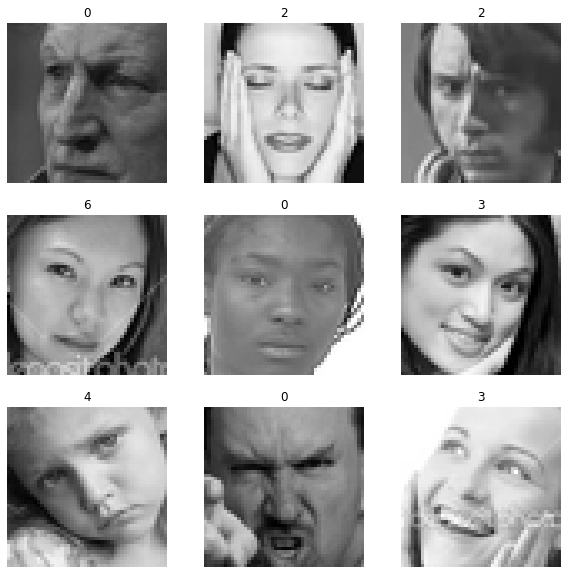

In [16]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    label = label_batch[i]
    plt.title(class_names[label])
    plt.axis("off")

In [18]:
from tensorflow.keras import layers

normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

num_classes = 7

model = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [19]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

Epoch 1/3
118/898 [==>...........................] - ETA: 30s - loss: 1.8355 - accuracy: 0.2240

UnknownError:  NewRandomAccessFile failed to Create/Open: C:\Users\tobia\Samlet CNN\data\train\5 : Access is denied.
; Input/output error
	 [[{{node ReadFile}}]]
	 [[IteratorGetNext]] [Op:__inference_train_function_1162]

Function call stack:
train_function
